[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://githubtocolab.com/devdastl/EVA-8_Capstone_Assignment/blob/main/Part1-training_ControlNet/part1_2-Training_ControlNet/part1_2_training_inference.ipynb)

# Prepare environment for training

- Lets attach our drive so that we can copy our prepared dataset to this instance for training.


In [1]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [2]:
dataset_path = "/content/gdrive/MyDrive/controlnet_dataset/dataset"

In [3]:
import os
!git clone https://github.com/devdastl/EVA-8_Capstone_Assignment.git
os.chdir('EVA-8_Capstone_Assignment/Part1-training_ControlNet/part1_2-Training_ControlNet')

#copy dataset from drive into the cloned repo
os.system(f"cp -r {dataset_path} ./")
!ls

Cloning into 'EVA-8_Capstone_Assignment'...
remote: Enumerating objects: 225, done.
remote: Counting objects: 100% (225/225), done.
remote: Compressing objects: 100% (185/185), done.
remote: Total 225 (delta 53), reused 201 (delta 33), pack-reused 0
Receiving objects: 100% (225/225), 5.17 MiB | 19.53 MiB/s, done.
Resolving deltas: 100% (53/53), done.
cldm				    models		 training.py
config.py			    requirements.txt	 tutorial_dataset.py
controlnet_training_capstone.ipynb  share.py
ldm				    tool_add_control.py


- Again lets setup python3.8 in our colab instance so that all dependency can be installed!
- This process can take some time
- If you are running on local then better to creaet a python env and make sure that the python version is 3.8

In [5]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8.10
!sudo update-alternatives --config python3
!apt install python3-pip

update-alternatives: --install needs <link> <name> <path> <priority>

Use 'update-alternatives --help' for program usage information.
There are 2 choices for the alternative python3 (providing /usr/bin/python3).

  Selection    Path                 Priority   Status
------------------------------------------------------------
* 0            /usr/bin/python3.10   2         auto mode
  1            /usr/bin/python3.10   2         manual mode
  2            /usr/bin/python3.8    1         manual mode

Press <enter> to keep the current choice[*], or type selection number: 2
update-alternatives: using /usr/bin/python3.8 to provide /usr/bin/python3 (python3) in manual mode
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  python-pip-whl python3-setuptools python3-wheel
Suggested packages:
  python-setuptools-doc
The following NEW packages will be installed:
  python-pip-whl python3-pip python

In [ ]:
!pip install pip install torch==1.12.1+cu116 torchvision==0.13.1+cu116 torchaudio==0.12.1 --extra-index-url https://download.pytorch.org/whl/cu116
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/, https://download.pytorch.org/whl/cu116
     |████████████████████████████████| 1904.8 MB 4.5 kB/s 
     |████████████████████████████████| 23.5 MB 1.3 MB/s 
     |████████████████████████████████| 3.8 MB 37.8 MB/s 
     |████████████████████████████████| 3.3 MB 25.0 MB/s 
     |████████████████████████████████| 62 kB 28 kB/s 
     |████████████████████████████████| 17.3 MB 76.0 MB/s 
     |████████████████████████████████| 156 kB 63.5 MB/s 
     |████████████████████████████████| 61 kB 122 kB/s 
     |████████████████████████████████| 123 kB 68.5 MB/s 
     |████████████████████████████████| 195 kB 79.0 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 14.2 MB 13.0 MB/s 
     |████████████████████████████████| 123 kB 80.0 MB/s 
     |████████████████████████████████| 49.2 MB 1.3 MB/s 
     |███

# Attach control part in stable diffusion
- Download stable diffusion v1.5 trained weights
- tool_add_control.py file attaches a copy of UNET encoder part to the stable diffusion architecture. This encoder wil be trained.
- code for attaching control, training and inference has been inspired from this repo [link](https://github.com/lllyasviel/ControlNet)

**NOTE** - "tool_add_control.py" uses CPU memeory to save model. This might not run on your free-teir colab and this process consume a lot of memory.
Make sure you can paid colab pro or you can do it locally in a large memory machine.

In [7]:
# download trined weights from huggingface
!wget https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned.ckpt -P ./models

--2023-05-27 17:19:06--  https://huggingface.co/runwayml/stable-diffusion-v1-5/resolve/main/v1-5-pruned.ckpt
Resolving huggingface.co (huggingface.co)... 99.84.160.37, 99.84.160.70, 99.84.160.73, ...
Connecting to huggingface.co (huggingface.co)|99.84.160.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/6b/20/6b201da5f0f5c60524535ebb7deac2eef68605655d3bbacfee9cce0087f3b3f5/e1441589a6f3c5a53f5f54d0975a18a7feb7cdf0b0dee276dfc3331ae376a053?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27v1-5-pruned.ckpt%3B+filename%3D%22v1-5-pruned.ckpt%22%3B&Expires=1685464068&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zLzZiLzIwLzZiMjAxZGE1ZjBmNWM2MDUyNDUzNWViYjdkZWFjMmVlZjY4NjA1NjU1ZDNiYmFjZmVlOWNjZTAwODdmM2IzZjUvZTE0NDE1ODlhNmYzYzVhNTNmNWY1NGQwOTc1YTE4YTdmZWI3Y2RmMGIwZGVlMjc2ZGZjMzMzMWFlMzc2YTA1Mz9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRpb24iOnsiRGF0ZUxlc3NU

*Remember that this line might not run completety on free colab as it will consume all available memory!

In [ ]:
!python tool_add_control.py ./models/v1-5-pruned.ckpt ./models/control_sd15_ini.ckpt

logging improved.
Enabled sliced_attention.
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
These weights are newly added: logvar
These weights are newly added: control_model.zero_convs.0.0.weight
These weights are newly added: control_model.zero_convs.0.0.bias
These weights are newly added: control_model.zero_convs.1.0.weight
These weights are newly added: control_model.zero_convs.1.0.bias
These weights are newly added: control_model.zero_convs.2.0.weight
These weights are newly added: control_model.zero_convs.2.0.bias
These weights are newly added: control_model.zero_convs.3.0.weight
These weights are newly added: control_model.zero_convs.3.0.bias
These weights are newly added: control_model

# Training our control attached architecture!
- while trainig you could also face this same issue of memory.
- once you are able to run below code, change the "max_time" value in line 32 in training.py 

**NOTE** - This model was trained for 24 hours to get the results shown in the readme. below are the values we used:
  - batch_size = 11
  - sliced_attention = True
  - images = 20k
more information is avaiable in the README section!

In [ ]:
!python3 training.py

logging improved.
Enabled sliced_attention.
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [./models/control_sd15_ini.ckpt]
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/workspace/capstone_assignment/env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:118: UserWarning: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
  rank_zero_warn("You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.")
/workspace/capstone_assignment/env/lib/python3.8/site-packages/pytorch_lightning/trainer/configuration_validator.py:280: Lightnin

copy the trained model to the attached drive!

In [ ]:
!cp ./models/trained_sd15_pet_v2_24h.ckpt /content/gdrive/MyDrive/controlnet_dataset/

# Running inference on our trained model
- here due to import issue in colab, I had to implement the inference code in python script.
- if you running on local server, then you can implement it directly in colab.
- remember the issue of less memory continues here as well.

here are the inputs for our inference:
- trained model -> ./models/trained_sd15_pet_v2_24h.ckpt
- input image -> ./dog_input_image.jpg
- prompt -> "A black dog sitting on the table"
- seed -> 661035870

**NOTE-** This inference code has been runned on the local machine on a model trained for 13 epochs on 20k images for 24 hours. Your output can vary based on your training.

In [1]:
!python run_inference.py

logging improved.
Enabled sliced_attention.
No module 'xformers'. Proceeding without it.
ControlLDM: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Loaded model config from [./models/cldm_v15.yaml]
Loaded state_dict from [/workspace/capstone_assignment/ControlNet/lightning_logs/version_0/checkpoints/24h.ckpt]
Global seed set to 661035870
Data shape for DDIM sampling is (5, 4, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps
DDIM Sampler: 100%|█████████████████████████████| 20/20 [00:40<00:00,  2.03s/it]


visualize our saved output

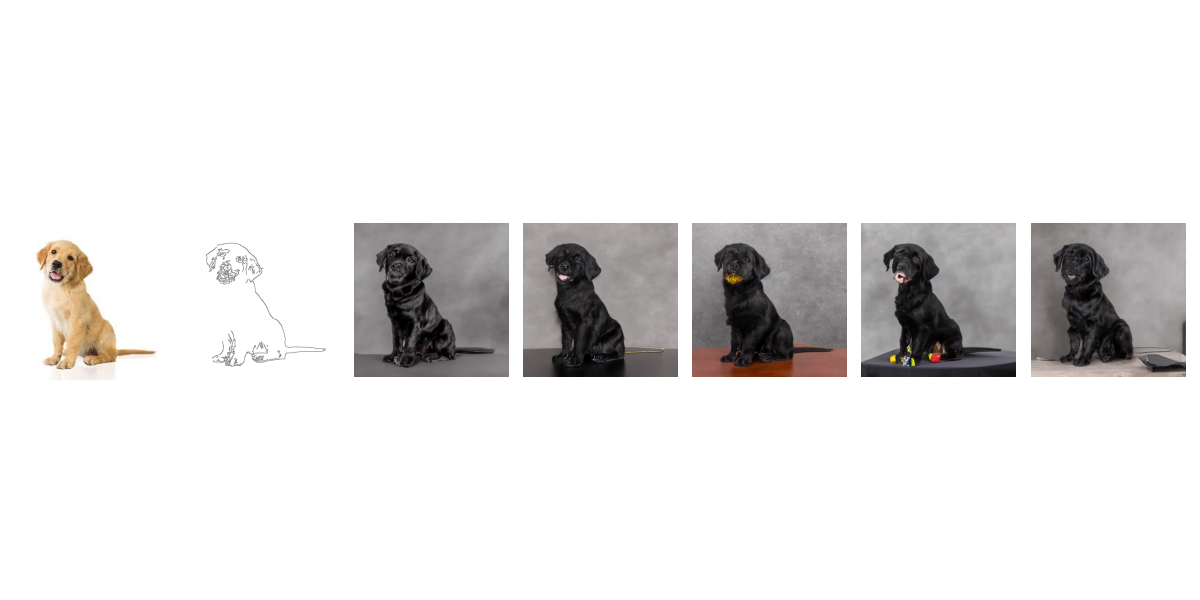

In [2]:
from PIL import Image
image = Image.open('output_image_dog.png')
image